# Let's get the Wikipedia places


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas
from wiki_dump_extractor import WikiSqlExtractor, download_file
from tqdm.auto import tqdm

## Download and parse the places

This dataset contains sites from wikipedia with latitude, longitude, and category.
It is not well curated, there are many sites without names, many sites without category, many pages which are just lists of things, some sites are actually on the moon, etc. We'll do what we can.

This takes typically 1-3mins.


In [7]:
data_dir = Path("wikipedia_data")
base_url = "https://dumps.wikimedia.org/enwiki/20250501/"
filename = "enwiki-20250501-geo_tags.sql.gz"
target_csv = data_dir / "wiki_places.csv.gz"

download_file(f"{base_url}{filename}", data_dir / filename, replace=False)

if not target_csv.exists():
    columns = ["gt_id", "gt_page_id", "gt_name", "gt_type", "gt_lat", "gt_lon"]
    table = WikiSqlExtractor(data_dir / filename)
    places_data_df = table.to_pandas_dataframe(columns=columns)
    places_data_df.to_csv(target_csv, index=False, compression="gzip")
places_data_df = pandas.read_csv(target_csv)

wikipedia_data/enwiki-20250501-geo_tags.sql.gz already exists, skipping download.


<unknown>:48: SyntaxWarning: invalid escape sequence '\w'
<unknown>:49: SyntaxWarning: invalid escape sequence '\w'
/Users/valentin/Documents/programming/wiki_dump_extractor/src/wiki_dump_extractor/wiki_sql_extractor.py:49: SyntaxWarning: invalid escape sequence '\w'
  ]


Processing rows: 0it [00:00, ?it/s]

Skipped lines: 2


## Download and parse the pages data

We'll use this data dump to extract page titles and lengths for each site in the places set.

This downloads 2.3Gb of data which takes ~8-10mins, then processes 63 million rows in 12-30mins.


In [11]:
filename = "enwiki-20250501-page.sql.gz"
download_file(f"{base_url}/{filename}", data_dir / filename, replace=False)

places_page_ids = set(places_data_df["gt_page_id"])

target_csv = data_dir / "wiki_pages.csv.gz"
if not target_csv.exists():
    table = WikiSqlExtractor(data_dir / filename)
    pages_df = table.to_pandas_dataframe(
        columns=["page_id", "page_title", "page_len"],
        row_filter=lambda row: row["page_id"] in places_page_ids,
    )
    pages_df.to_csv(target_csv, index=False, compression="gzip")
pages_df = pandas.read_csv(target_csv)

wikipedia_data/enwiki-20250501-page.sql.gz already exists, skipping download.


Processing rows: 0it [00:00, ?it/s]

Skipped lines: 2


## Filter places, add geohashes

We filter all the places with latitude and longitude that not in the usual earthly range, because these are mostly on other planets (that was weird to me, I thought every planet had the same -180/180, -90/90 coordinates but maybe not)


In [12]:
full_df = places_data_df.merge(pages_df, left_on="gt_page_id", right_on="page_id")
full_df.rename(
    columns={
        "gt_name": "name",
        "gt_lat": "lat",
        "gt_lon": "lon",
        "gt_type": "category",
    },
    inplace=True,
)
full_df["page_title"] = full_df.page_title.str.replace("_", " ")
off_limit_coordinates = (full_df["lat"].abs() > 90) | (full_df["lon"].abs() > 180)
full_df[off_limit_coordinates][["page_title"]]

,page_title
6157,The Anome/Offplanet places containing plaintex...
6158,The Anome/Offplanet places containing plaintex...
6159,The Anome/Offplanet places containing plaintex...
6161,The Anome/Offplanet places containing plaintex...
6162,The Anome/Offplanet places containing plaintex...
...,...
2591752,Kunisada (crater)
2591753,Dali (crater)
2591755,Mahsati (crater)
2598367,Tarsus (crater)


In [ ]:
import lmdb

generated_data_dir = Path("generated_data")
filtered_raw_places_csv = generated_data_dir / "filtered_raw_places.csv"
if not filtered_raw_places_csv.exists():
    wiki_dump_index_db = data_dir / "wiki_dump_index_db"
    with lmdb.open(str(wiki_dump_index_db), readonly=True) as env:
        with env.begin() as txn:
            page_titles = set(
                key.decode() for key in txn.cursor().iternext(keys=True, values=False)
            )
    is_in_wiki_dump = full_df.page_title.isin(page_titles)
    from_list = full_df.page_title.str.contains("List of")
    from_user = full_df.page_title.str.contains("/")
    is_crater = full_df.page_title.str.lower().str.contains("crater")
    is_pic = full_df.page_title.str.lower().str.contains("jpg")
    df = full_df[
        is_in_wiki_dump
        & (~off_limit_coordinates)
        & (~from_list)
        & (~from_user)
        & (~is_crater)
        & (~is_pic)
    ].copy()
    df.to_csv(filtered_raw_places_csv, index=False)
    print("Length before filtering", len(full_df))
    print("Length after filtering", len(df))


### Attribute geohashes to the entries


In [23]:
def encode_hybrid(lat, lon, base4_precision=8):
    """
    Encode a latitude/longitude pair into a hybrid geohash string.

    Uses base32 encoding for the first character (5 bits) followed by base4 encoding
    (quadtree) for subsequent characters.

    Parameters
    ----------
    lat : float
        Latitude between -90 and 90
    lon : float
        Longitude between -180 and 180
    base4_precision : int, optional
        Number of base4 characters to use after initial base32 char.
        Default is 8.

    Returns
    -------
    str
        Hybrid geohash string with one base32 character followed by base4_precision
        base4 digits

    Notes
    -----
    The first character uses base32 encoding to provide initial rough positioning,
    while subsequent characters use quadtree-based base4 encoding for more precise
    location refinement.
    """
    # Start with base32 encoding for the first character
    lat_range = [-90, 90]
    lon_range = [-180, 180]
    _base32 = "0123456789bcdefghjkmnpqrstuvwxyz"

    hashcode = ""
    bits = [16, 8, 4, 2, 1]
    bit = 0
    ch = 0

    # First char (base32, 5 bits)
    for i in range(5):
        if bit % 2 == 0:
            mid = (lon_range[0] + lon_range[1]) / 2
            if lon > mid:
                ch |= bits[i]
                lon_range[0] = mid
            else:
                lon_range[1] = mid
        else:
            mid = (lat_range[0] + lat_range[1]) / 2
            if lat > mid:
                ch |= bits[i]
                lat_range[0] = mid
            else:
                lat_range[1] = mid
        bit += 1
    hashcode += _base32[ch]

    # Now subsequent chars: base4 encoding (quadtree)
    for _ in range(base4_precision):
        mid_lat = (lat_range[0] + lat_range[1]) / 2
        mid_lon = (lon_range[0] + lon_range[1]) / 2

        quadrant = 0
        if lat >= mid_lat:
            quadrant += 2  # north
            lat_range[0] = mid_lat
        else:
            lat_range[1] = mid_lat

        if lon >= mid_lon:
            quadrant += 1  # east
            lon_range[0] = mid_lon
        else:
            lon_range[1] = mid_lon

        hashcode += str(quadrant)

    return hashcode


target = generated_data_dir / "filtered_raw_places_with_geohashes.csv"
if not target.exists():
    df = pandas.read_csv(generated_data_dir / "filtered_raw_places.csv")
    df["geohash4"] = [
        encode_hybrid(lat, lng, base4_precision=19)
        for lat, lng in zip(df["lat"], df["lon"])
    ]
    df.to_csv(target, index=False)
df = pandas.read_csv(generated_data_dir / "filtered_raw_places_with_geohashes.csv")

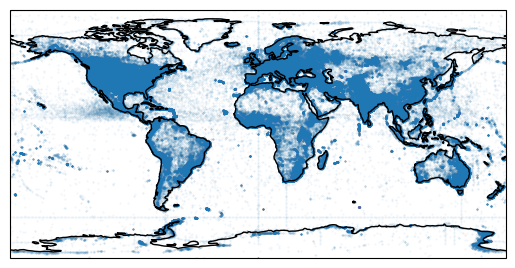

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


def plot_df(df, **scatter_kwargs):
    plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax.scatter(df["lon"], df["lat"], transform=ccrs.PlateCarree(), **scatter_kwargs)
    return ax


plot_df(df, s=0.1, alpha=0.1);

### Compute the geohashes for each site

We will use this modified geohash (it uses mostly base-4, which is perfect because the leaflet zoom basically zooms by factors of 2/4).

We will also use the geohashes to deduplicate entries - but not before we've sorted the pages in the most interesting order possible.


### Keep cities over events that happened in the cities

We want to know which entries are cities so we make sure to keep them.

Keeping cities is important because users will search for e.g. "Paris" in search bar.
We need to make sure that Paris is in the database, and hasn't been replaced by "2024 Olympics", just because the latter has the same location has a larger wikipedia page.


In [31]:
data_dir = Path("wikipedia_data")
cities_zip = data_dir / "cities5000.zip"
filepath = "enwiki-20250220-page.sql.gz"

download_file(
    "https://download.geonames.org/export/dump/cities5000.zip",
    cities_zip,
    replace=False,
)
columns = [
    "geonameid",
    "name",
    "asciiname",
    "alternatenames",
    "latitude",
    "longitude",
    "feature class",
    "feature code",
    "country code",
    "cc2",
    "admin1 code",
    "admin2 code",
    "admin3 code",
    "admin4 code",
    "population",
    "elevation",
    "dem",
    "timezone",
    "modification date",
]
cities_df = pandas.read_csv(cities_zip, sep="\t", header=None, names=columns)
cities_df
city_names = set(cities_df.asciiname.str.lower())
df["is_city"] = df.page_title.str.lower().isin(city_names)
sum(df.is_city)

wikipedia_data/cities5000.zip already exists, skipping download.


36021

### Define a score for each location

It is defined as page_length / number_of_locations_in_page.

It will be used so that locations with larger wikipedia page appear preferentially.


In [28]:
from wiki_dump_extractor import WikiAvroDumpExtractor, page_utils

dump = WikiAvroDumpExtractor("wiki_dump.avro", index_dir="../wiki_dump_idx")


def clean_text(text):
    text = page_utils.remove_appendix_sections(text)
    text = page_utils.replace_titles_with_section_headers(text)
    text = page_utils.remove_comments_and_citations(text)
    return text

(0.0, 8000.0)

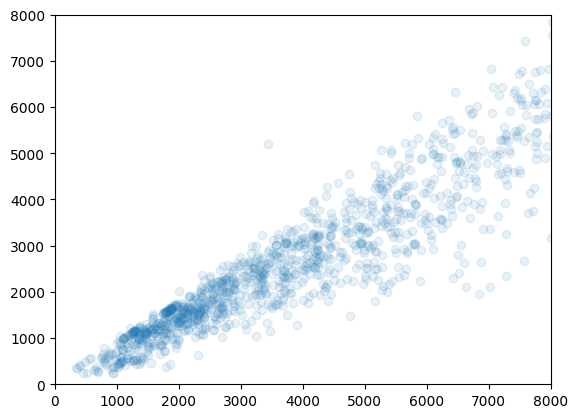

In [32]:
import matplotlib.pyplot as plt

subdf = df[::1000]
titles = subdf["page_title"].str.replace("_", " ").tolist()
wiki_lens = subdf["page_len"].tolist()
dump = WikiAvroDumpExtractor(
    data_dir / "wiki_dump.avro", index_dir=data_dir / "wiki_dump_index_db"
)
pages = dump.get_page_batch_by_title(titles)
eng_lens = [len(clean_text(p.text)) for p in pages]

fig, ax = plt.subplots()
ax.plot(wiki_lens, eng_lens, "o", linewidth=0, alpha=0.1)
ax.set_ylim(0, 8_000)
ax.set_xlim(0, 8_000)


In [33]:
import json

target = Path(generated_data_dir / "length_by_page.json")
if not target.exists():
    df_batches = (df[i : i + 1000] for i in range(0, len(df), 1000))
    length_by_page = {}
    for batch in tqdm(df_batches):
        titles = batch["page_title"].tolist()
        pages = dump.get_page_batch_by_title(titles)
        page_lengths = [len(clean_text(p.text)) for p in pages]
        length_by_page.update(dict(zip(titles, page_lengths)))

    with open(target, "w") as f:
        json.dump(length_by_page, f)


with open(target, "r") as f:
    length_by_page = json.load(f)

df["true_page_len"] = df["page_title"].map(length_by_page.get)

0it [00:00, ?it/s]

In [34]:
page_occurences = df.groupby("page_title")["page_title"].count().to_dict()
df["score"] = [
    page_len / page_occurences[page_title]
    for page_title, page_len in zip(df["page_title"], df["true_page_len"])
]
df = df.sort_values(["is_city", "score"], ascending=False)
df = df.drop_duplicates(subset=["geohash4"])
df = df.sort_values("score", ascending=False)
"Paris" in set(df.page_title)

True

### Attribute a "zoom level" to each location

This is used to reveal the locations as the user zooms in


We sort the sites by decreasing score now. This is the order they will be in the database. It's a nice way to always now that the elements returned are sorted by relevance.


In [36]:
# Assign events to geokeys
dots_by_geokey = {}
geohash_to_geokey = {}

for geohash4 in tqdm(df["geohash4"]):
    prefix = ""
    for prefix_length in range(1, len(geohash4) + 1):
        prefix = geohash4[:prefix_length]
        if prefix not in dots_by_geokey:
            if geohash4 not in geohash_to_geokey:
                geohash_to_geokey[geohash4] = prefix
                dots_by_geokey[prefix] = {}
            else:
                geokey = geohash_to_geokey[geohash4]
                dots_by_geokey[prefix] = dots_by_geokey[geokey]
        else:
            zoom_level = prefix_length
            if zoom_level not in dots_by_geokey[prefix]:
                dots_by_geokey[prefix][zoom_level] = []
            dots = dots_by_geokey[prefix][zoom_level]
            if len(dots) < 10:
                surprefix = geohash4[: prefix_length + 3]
                dot_surprefixes = [d[: prefix_length + 3] for d in dots]
                if surprefix not in dot_surprefixes:
                    dots_by_geokey[prefix][zoom_level].append(geohash4)

  0%|          | 0/1633108 [00:00<?, ?it/s]

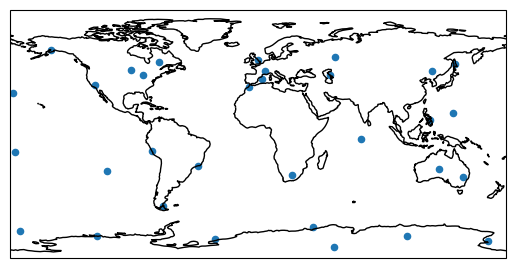

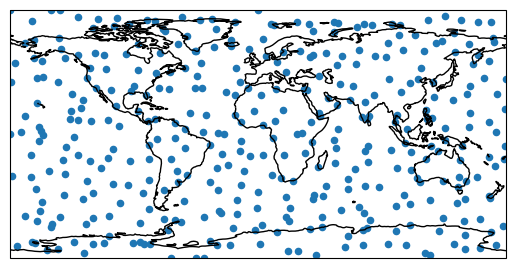

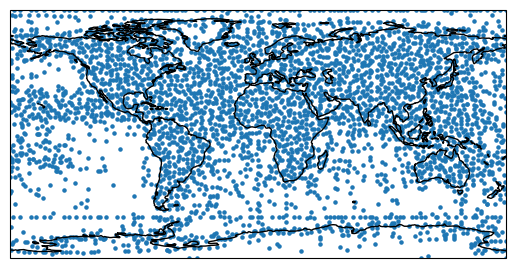

In [37]:
df["geokey"] = [geohash_to_geokey.get(gh4, gh4) for gh4 in df["geohash4"]]
df["geokey_complement"] = df["geokey_complement"] = [
    geohash[len(geokey) :] for geohash, geokey in zip(df["geohash4"], df["geokey"])
]
df["zoom_level"] = df["geokey"].str.len()
plot_df(df.query("zoom_level == 1"), s=20, alpha=1)
plot_df(df.query("zoom_level == 3"), s=20, alpha=1)
plot_df(df.query("zoom_level == 5"), s=5, alpha=1);


In [39]:
df.to_csv(generated_data_dir / "places_final.csv", index=False)

In [38]:
import json
import zlib


def get_zipped_dots(geohash):
    geokey = geohash_to_geokey[geohash]
    dots = dots_by_geokey[geokey]
    json_data = json.dumps(dots)
    return zlib.compress(json_data.encode("utf-8"))


df["dots"] = [get_zipped_dots(gh4) for gh4 in tqdm(df["geohash4"])]

  0%|          | 0/1633108 [00:00<?, ?it/s]

## Write the data to disk

Unfortunately the only way we'll be able to send that data to cloudflare is if we write in into small SQL files (it has to be `.sql` files).

So here we first build the SQL commands, then we'll write them to disk (for Cloudflare upload) at the same time that we use them to populate our local sqlite database (which we'll use for local development)


In [48]:
from db_utils import SqliteTableBatchWriter, open_sqlite_db

# Create database and table
places_db = open_sqlite_db(generated_data_dir / "places.sqlite", replace=True)
writer = SqliteTableBatchWriter(
    db=places_db,
    table="places",
    index_key="geokey",
    text_indexed_fields=["name", "page_title"],
    batch_size=10000,
)

writer.execute(
    command="""
CREATE TABLE IF NOT EXISTS places (
    geokey TEXT PRIMARY KEY,
    geokey_complement TEXT,
    category TEXT,
    name TEXT,
    dots TEXT NULL,
    page_title TEXT
);
"""
)

print("Sorting from highest to lowest score...")
df = df.sort_values("score", ascending=False)
df["name"] = df["name"].fillna("")
df["category"] = df["category"].fillna("")

# Add each record to the batch writer
print("Adding records to the database...")
needed_columns = [
    "geokey",
    "geokey_complement",
    "category",
    "name",
    "dots",
    "page_title",
]
records = df[needed_columns].to_dict("records")
for record in tqdm(records):
    writer.add_record_to_db_table(record)

# Make sure to insert any remaining records
writer.insert_records()

print("Building the indexes...")
writer.index()
writer.index_text()

Sorting from highest to lowest score...
Adding records to the database...


  0%|          | 0/1633108 [00:00<?, ?it/s]

Building the indexes...


In [31]:
!cp places_db.sqlite ../../landnotes/worker/.wrangler/state/v3/d1/miniflare-D1DatabaseObject/e66eef3cbd4565d3e69f1f2434191bfdb37ef22f3df39fee3383b9b23eb1612d.sqlite
!rm -rf ../../landnotes/worker/local_assets/sql_dump
!cp -r sql_dump/ ../../landnotes/worker/local_assets/sql_dump

## Create a database of the pages with geolocation


In [6]:
from utils import db_utils
from pathlib import Path
import json
from tqdm.auto import tqdm
import pandas

wiki_data_dir = Path("wikipedia_data")
generated_data_dir = Path("generated_data")

target = generated_data_dir / "locations_by_page_title_db"
if True or not target.exists():
    df = pandas.read_csv(generated_data_dir / "filtered_raw_places_with_geohashes.csv")
    page_titles = set(df.page_title)
    with db_utils.LMDBWriter(target) as db:
        records = [
            (
                row.page_title.encode(),
                json.dumps(
                    {
                        "geohash4": row.geohash4,
                        "name": row.name,
                        "page_title": row.page_title,
                    }
                ).encode(),
            )
            for row in df.itertuples()
        ]

        db.write_batch(records)
        redirects_batch = []
        with db_utils.LMDBReader(
            wiki_data_dir / "wiki_dump_redirects_db"
        ) as redirects_db:
            for page_title, redirect_page_title in tqdm(redirects_db):
                if redirect_page_title.decode() in page_titles:
                    location_data = db.get(redirect_page_title)
                    redirects_batch.append((page_title.encode(), location_data))
        print("Added via redirects:", len(redirects_batch))
        db.write_batch(redirects_batch)


0it [00:00, ?it/s]

Added via redirects: 1989915
